## Context
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import sklearn
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
!pip install vaderSentiment

In [3]:
# loading dataset
path = '/kaggle/input/amazon-fine-food-reviews/'
reviews = pd.read_csv(path+"Reviews.csv")

In [4]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
reviews.shape

(568454, 10)

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


`Observe`:
* `ProductId`
    * might be used to either aggregate reviews against a single product or 
    * maybe pulling additional metadata from Amazon on what these products are
* `UserId` and `ProfileName` both related with reviewer
    *  how UserId can change overtime as ProfileName can be changed overtime (not that usefull)
Interesting would be to try to track `evolution of reviews` of frequent reviewers, see we have several columns for other people rating reviews
* `Score` reviewer rating on a product
* `Time` in `timestamp string format` and needs to be converted to be able to do longitudinal analysis
* `Summary` and `Text` tag line and actual summary of text

Alternative view of data by using summary statistics

In [7]:
reviews.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


`Observe`:
* `score` seems to be between 1 and 5 which is expected 
* most of the reviews are right skewed in it's `helpfulness` with some very strong outliers
    * `helpfulness` columns will need to be normalized in order to be useful

In [8]:
# number of missing data in this dataset
reviews.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

`Observe`:
Most of the data is filled in with some exceptions in `ProfileName` and `Summary`

# `EDA`
### `Feature Engineering`

### Helpfulness Features
First--performig some minor feature engineering<br>
To get percentage of and rescale helpfulness by dividing numerator by denominator

In [9]:
# calculating Helpfulness percentage
reviews["Helpfulness"] = reviews["HelpfulnessNumerator"]/reviews["HelpfulnessDenominator"] # it will produce some nan
# filling above nan values with 0
reviews['Helpfulness'].fillna(0).head()
reviews["Helpfulness"].mean()

0.776974535871338

### Review Lengths (Summary Feature)
* Looking into Review Lengths 
    * This could be a simple metric related to score of reviews
    * For instance, longer reviews might be more passionate so it could have a higher score and vice versa
* `First, Imputinh missing `Summary` titles with blanks`

In [10]:
# total null counts in Summary Feature
reviews["Summary"].isnull().sum()

27

In [11]:
# imputing missing titles with ''-blank
reviews["Summary"] = reviews["Summary"].fillna('')

Now `Calculating lengths of text`

In [12]:
# calculating summary lengths
reviews["Summary_length"] = reviews["Summary"].map(lambda x: len(x.split()))

# calculating review lengths
reviews["Text_length"] = reviews["Text"].map(lambda x: len(x.split()))

### Timestamp (Time Feature)
Fixing Time Feature in order to use it

In [13]:
reviews["Time"].dtype

dtype('int64')

In [14]:
reviews["Time"] = pd.to_datetime(reviews.Time,  unit='s')
reviews["Time"].dtype

dtype('<M8[ns]')

### Sentiment Score (Text,Summary Features)
Maybee correlating Sentiment of a review against the score will be intrusting
* Using [Vader Link](https://github.com/cjhutto/vaderSentiment) which is a `rules based approach` to classifying Reviews

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# initealize Sentiment analyzer
analyser = SentimentIntensityAnalyzer()

# scorer function based on cutoffs
def score_sentiment(compound_score):
    if compound_score >= 0.05:
        return("Positive")
    elif compound_score < 0.05 and compound_score >= -0.05:
        return("Neutral")
    else:
        return("Negative")

In [16]:
reviews["Text_sentiment"] = reviews["Text"].map(lambda x: score_sentiment(analyser.polarity_scores(x)['compound']))
reviews["Summary_sentiment"] = reviews["Summary"].map(lambda x: score_sentiment(analyser.polarity_scores(x)['compound']))

In [17]:
reviews["Text_sentiment"].head()

0    Positive
1    Negative
2    Positive
3    Positive
4    Positive
Name: Text_sentiment, dtype: object

In [18]:
reviews["Summary_sentiment"].head()

0    Positive
1     Neutral
2    Positive
3     Neutral
4    Positive
Name: Summary_sentiment, dtype: object

# `Simple Stats`
First, trying to look at distributions of all of variables to get an idea of what this dataset looks like

### Reviews Over Time (Time Feature)

In [19]:
pd.DatetimeIndex(reviews['Time']).year.value_counts()

2012    198659
2011    163299
2010     85884
2009     55326
2008     34163
2007     22300
2006      6671
2005      1335
2004       561
2003       132
2002        73
2000        32
2001        13
1999         6
Name: Time, dtype: int64

`Observe` above raw values, dataset starts from 1999-2012
* 2001 and 2000 are likely mislabeled in this case as it doesn't make sense exponential growth wise but 
    * as that time was roughly around dot com bubble bursting, it could be apparently valid and will be left alone

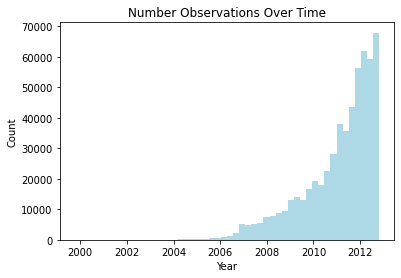

In [20]:
# plottig number of reviews overtime
plt.hist(reviews["Time"], bins=50, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Number Observations Over Time')
plt.show()

`Observe` above plot that number of reviews in this dataset exponentially grew over years up to 2012

In [21]:
pd.DatetimeIndex(reviews['Time']).year == '2000'

array([False, False, False, ..., False, False, False])

### Score count

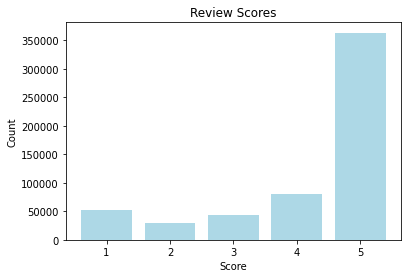

In [22]:
# plotting number of scores 
score_counts = reviews["Score"].value_counts().to_dict()
plt.bar(score_counts.keys(),height=score_counts.values(),color='lightblue')
plt.ylabel('Count')
plt.xlabel('Score')
plt.title('Review Scores')
plt.show()

`Observe` most of reviews are 5 stars
* In modeling, this will be an issue

### Sentiment Distribution
I have sentiment of Text and Summary
* Trying to see roughly what predicted sentiments are

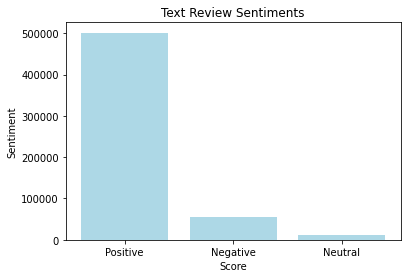

In [23]:
# Text_sentiment
text_sentiment_counts = reviews["Text_sentiment"].value_counts().to_dict()
plt.bar(text_sentiment_counts.keys(),height=text_sentiment_counts.values(),color='lightblue')
plt.ylabel('Sentiment')
plt.xlabel('Score')
plt.title('Text Review Sentiments')
plt.show()

`Observe` most of reviews are considered postiive 
* This is somewhat expected as most of reviews have 5 stars so reasonably would assume that it would be overwhelmingly positive as well

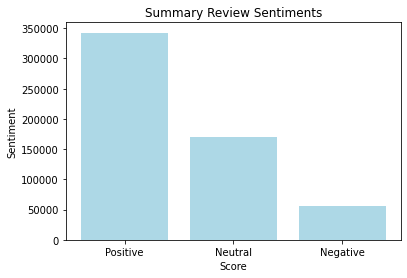

In [24]:
# Summary_sentiment
summary_sentiment_counts = reviews["Summary_sentiment"].value_counts().to_dict()
plt.bar(summary_sentiment_counts.keys(),height=summary_sentiment_counts.values(),color='lightblue')
plt.ylabel('Sentiment')
plt.xlabel('Score')
plt.title('Summary Review Sentiments')
plt.show()

`Observe` Summary_text shows a similar trend as Review_text
* Interesting difference is that something is causing this algorithm to give high neutral scores

### GroupBy
**`It would be good to look at Sentiment in relationship to Score`**

In [25]:
reviews_sentiment_count = reviews.groupby(['Score','Text_sentiment','Summary_sentiment']).count()[["Id"]].reset_index().rename(columns = {"Id": "Count"})
reviews_sentiment_count.head()

,Score,Text_sentiment,Summary_sentiment,Count
0,1,Negative,Negative,11559
1,1,Negative,Neutral,9691
2,1,Negative,Positive,2349
3,1,Neutral,Negative,813
4,1,Neutral,Neutral,1596


Use of `melt`<br>
Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.

This function is useful to massage a DataFrame into a format where one
or more columns are identifier variables (`id_vars`), while all other
columns, considered measured variables (`value_vars`), are "unpivoted" to
the row axis, leaving just two non-identifier columns, 'variable' and
'value'.

In [26]:
melted_reviews = pd.melt(reviews_sentiment_count,id_vars=['Score','Text_sentiment','Summary_sentiment'],value_vars=['Count'])
melted_reviews.head()

,Score,Text_sentiment,Summary_sentiment,variable,value
0,1,Negative,Negative,Count,11559
1,1,Negative,Neutral,Count,9691
2,1,Negative,Positive,Count,2349
3,1,Neutral,Negative,Count,813
4,1,Neutral,Neutral,Count,1596


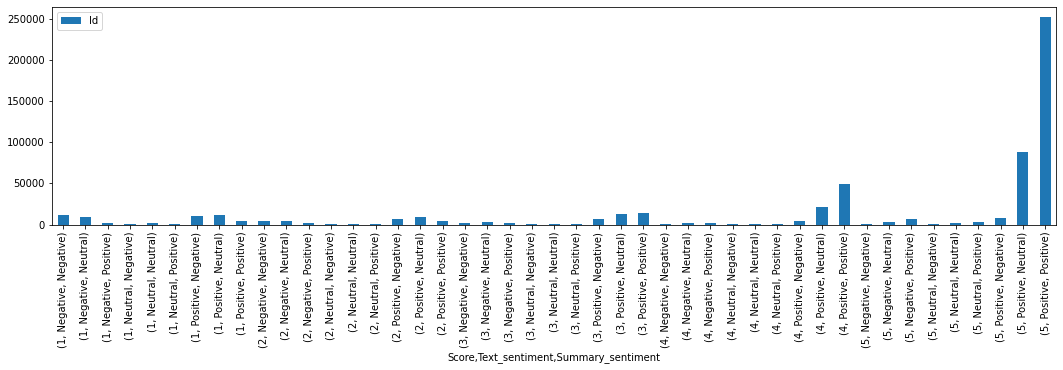

In [27]:
reviews.groupby(['Score','Text_sentiment','Summary_sentiment']).count()[["Id"]].plot.bar(figsize=(18,4))
plt.show()

`Observe` from this plot it looks like most of sentiments that are 5 star are positive in both the reviews and summary
* same applies for 4 star reviews

It should be checked if the `Summary` and `Reviews` are correlated
* It's expected but would be interesting to see if they are truely correlated

In [28]:
from scipy.stats import spearmanr

spearmanr(reviews["Text_sentiment"], reviews["Summary_sentiment"])

SpearmanrResult(correlation=0.271105244424719, pvalue=0.0)

`Observe` sentiment between `Text_sentiment` and `Summary_sentiment` are weakly but significantly correlated

**`Finally, should also check their relationship to Score in case one want to try to model their relationship`**

In [29]:
spearmanr(reviews["Text_sentiment"], reviews["Score"])

SpearmanrResult(correlation=0.38061699756503703, pvalue=0.0)

`Observe` that Text_sentiment is also weakly but significantly correlated to Score

In [30]:
spearmanr(reviews["Summary_sentiment"], reviews["Score"])

SpearmanrResult(correlation=0.41804461754622485, pvalue=0.0)

`Observe` that Summary_sentiment is also weakly but significantly correlated to Score

### Reviewers Engagement
Based on `UserId`, trying to understand who the top reviewers are 
* These people are most engaged and would likely have high helpfulness due to honing their writing skills, and experience

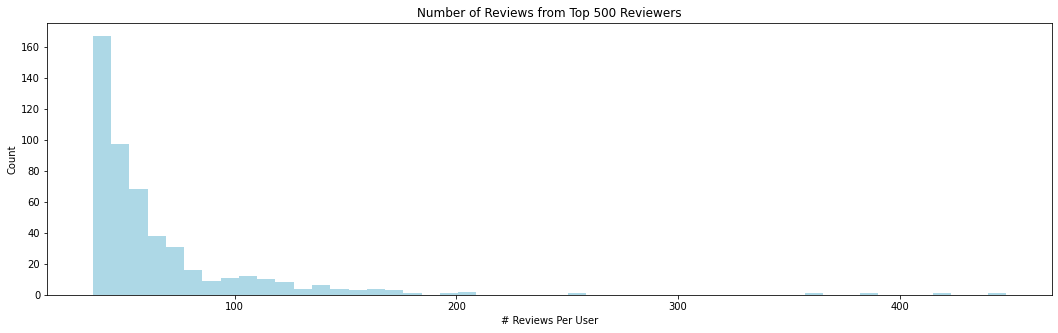

In [31]:
top_500_reviewers_count = reviews["UserId"].value_counts().nlargest(500)

plt.figure(figsize=(18,5))
plt.hist(top_500_reviewers_count,bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Reviews Per User')
plt.title('Number of Reviews from Top 500 Reviewers')
plt.show()

`Observe` the plot above, from top 500 reviewers number of reviews are right skewed
* Most of users in this selection have about 30-40 reviews

**`Trying to see if over time users write longer posts`**

In [32]:
top_users = reviews.loc[reviews['UserId'].isin(top_500_reviewers_count.index)]
top_users = top_users.sort_values(['UserId', 'Time'])
top_users.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Summary_length,Text_length,Text_sentiment,Summary_sentiment
192071,192072,B000HDEHSQ,A100WO06OQR8BQ,"Duffer. ""Bo""",0,0,3,2007-09-17,Average Taste,Nothing special about this item. Tastes fairly...,NaN,2,23,Negative,Neutral
151158,151159,B001Q9EFW8,A100WO06OQR8BQ,"Duffer. ""Bo""",0,0,5,2009-07-05,Very Good,The first time I gave my dog one of these he s...,NaN,2,60,Positive,Positive


In [33]:
# creating numbered entry per person based on sorted list of userid above
review_times_vector = [[j + 1 for j in range(i)] for i in top_500_reviewers_count[top_500_reviewers_count.index.sort_values()]]
review_times_vector_flat = [item for sublist in review_times_vector for item in sublist]

# adding numbered review order
top_users["Review_times"] = review_times_vector_flat

##### Expanding above code line after line

In [34]:
top_500_reviewers_count[top_500_reviewers_count.index.sort_values()]

A100WO06OQR8BQ     55
A106ZCP7RSXMRU     60
A1080SE9X3ECK0     72
A10AFVU66A79Y1     41
A10G136JEISLVR     51
                 ... 
AYNAH993VDECT      38
AYOMAHLWRQHUG      79
AYQ8RLE0K6RU8      44
AYWUHB7N8XGZQ      46
AZV26LP92E6WU     167
Name: UserId, Length: 500, dtype: int64

"""# alternate review_times_vector_flat
for sublist in review_times_vector:
    for item in sublist:
        print(item)

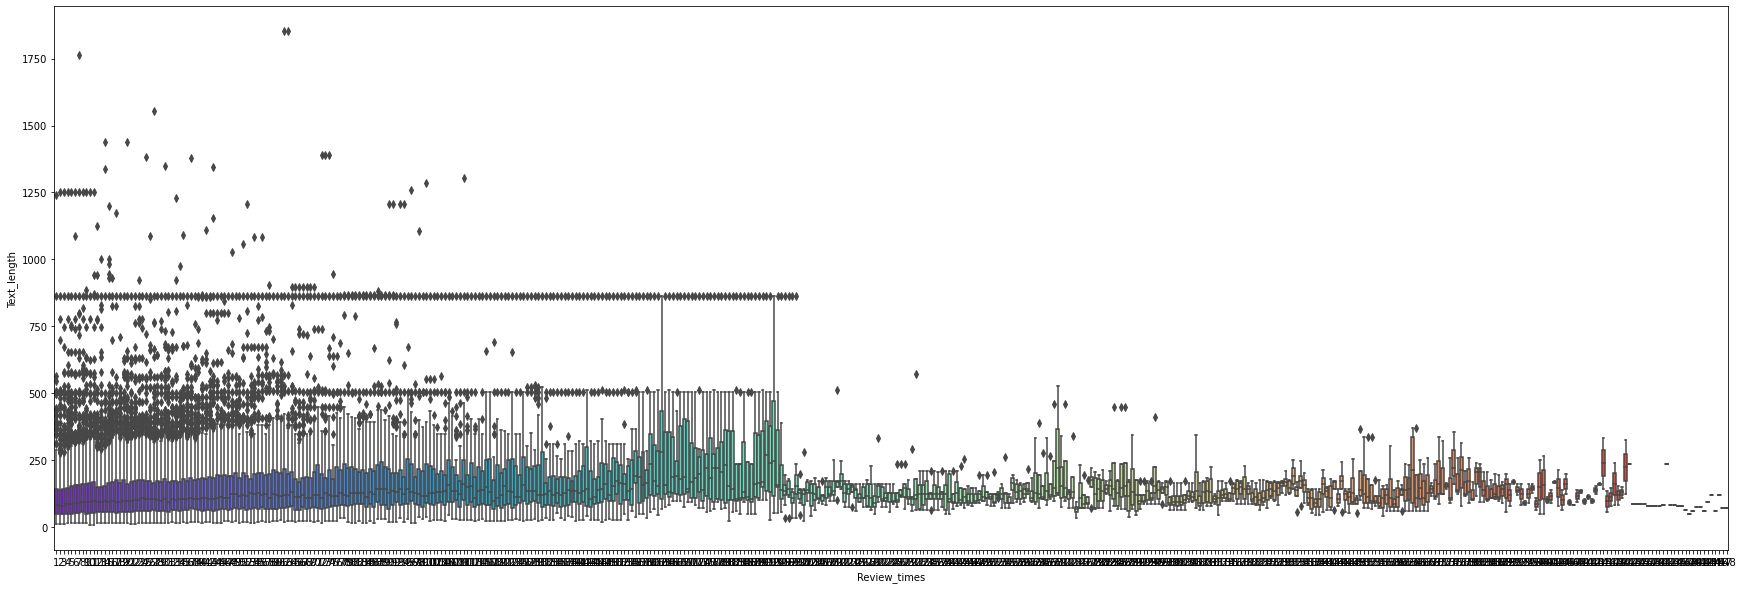

In [36]:
plt.figure(figsize=(30,10))

sns.boxplot(y='Text_length',x='Review_times',data=top_users,palette="rainbow")
plt.show()

`Observe` box plot above shows the ReviewText_length in relation to NumberOfReviews that person has written so far
* Two general trends here are
    * In the left half, distribution gets wider over time
    * In the right half, box plots mostly shrink as number of people who write that much get fewer and fewer

**`Trying to look closer between two and see if there is any meaningful difference`**

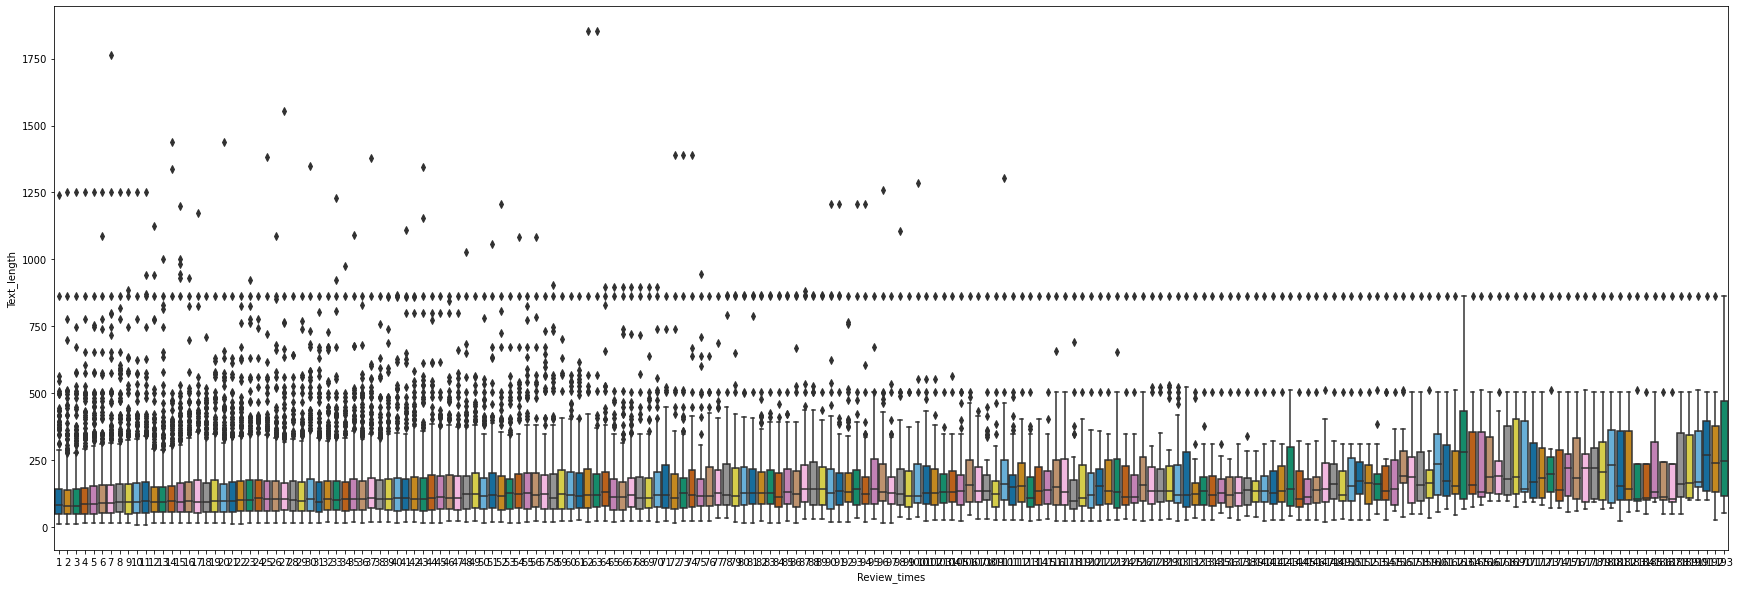

In [37]:
# review < 194
plt.figure(figsize=(30,10))
sns.boxplot(y='Text_length',x='Review_times',data=top_users[top_users["Review_times"] < 194],palette="colorblind")
plt.show()

`Observe` the median slowly increases overtime

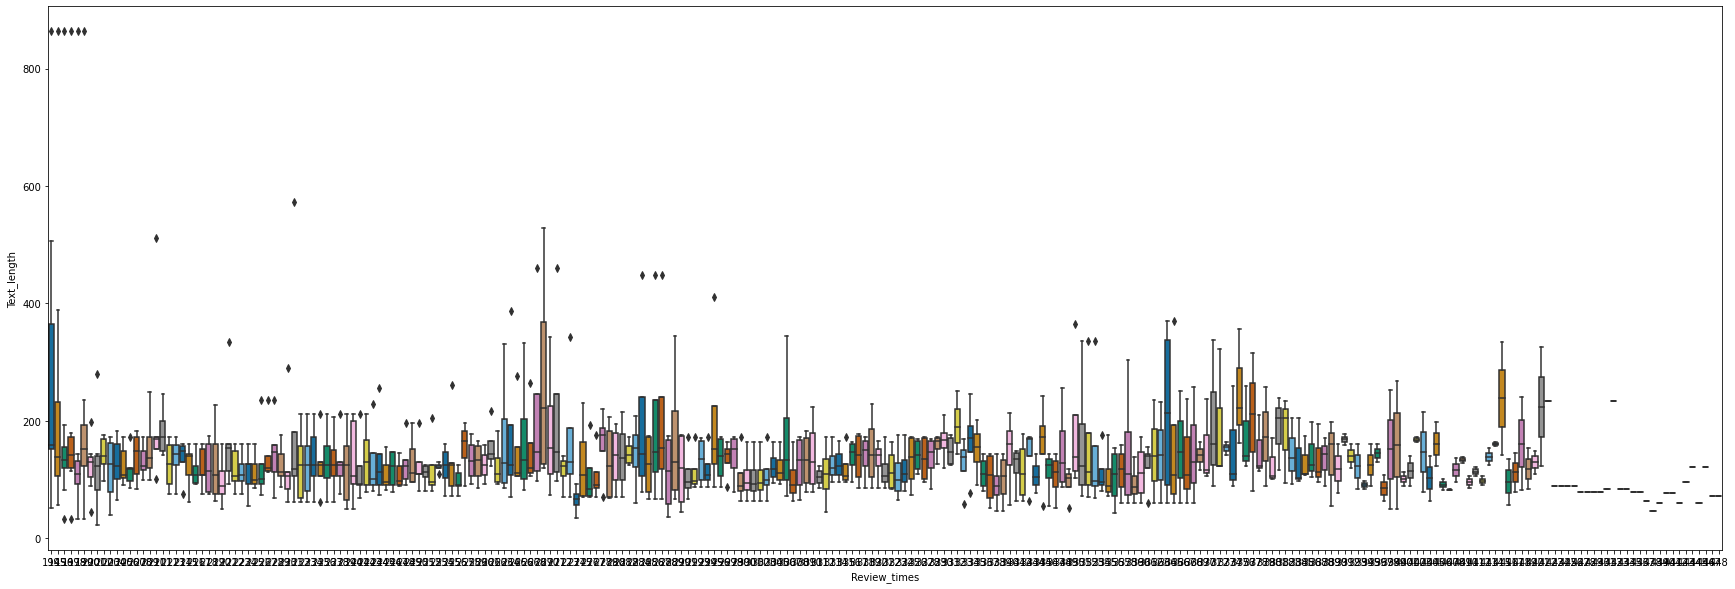

In [38]:
# review >=1914
plt.figure(figsize=(30,10))
sns.boxplot(y='Text_length',x='Review_times',data=top_users[top_users["Review_times"] >= 194],palette="colorblind")
plt.show()

`Observe` after 195 reviews median begins to drop
* This could be sample size problems or it could be that people also get lazy after writing so much

In [39]:
# text length
text_length_df = top_users.groupby(top_users.Review_times)[['Text_length']].median()
text_length_df.reset_index(level=0, inplace=True)
text_length_df['Review_times'] = pd.to_numeric(text_length_df['Review_times'])
text_length_df.head()

,Review_times,Text_length
0,1,83.0
1,2,78.0
2,3,79.5
3,4,85.0
4,5,86.0


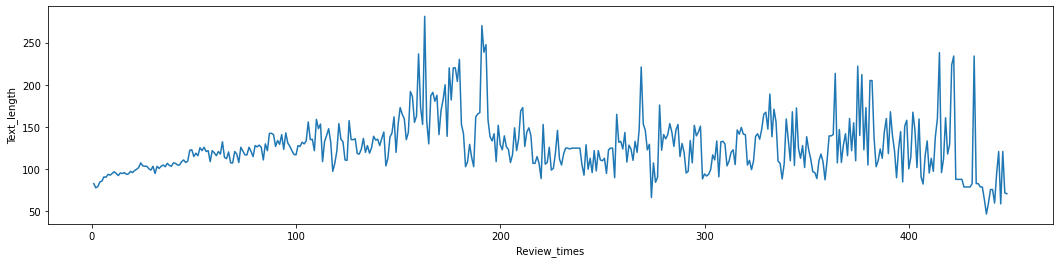

In [40]:
plt.figure(figsize=(18,4))
sns.lineplot(y='Text_length',x='Review_times',data=text_length_df)
plt.show()

`Observe` plot above shows trend observed with box plots 
* Line represents `median text length` over course of a review's lifetime in dataset
* Reviews do increase until it fluctuates back down to roughly initial levels

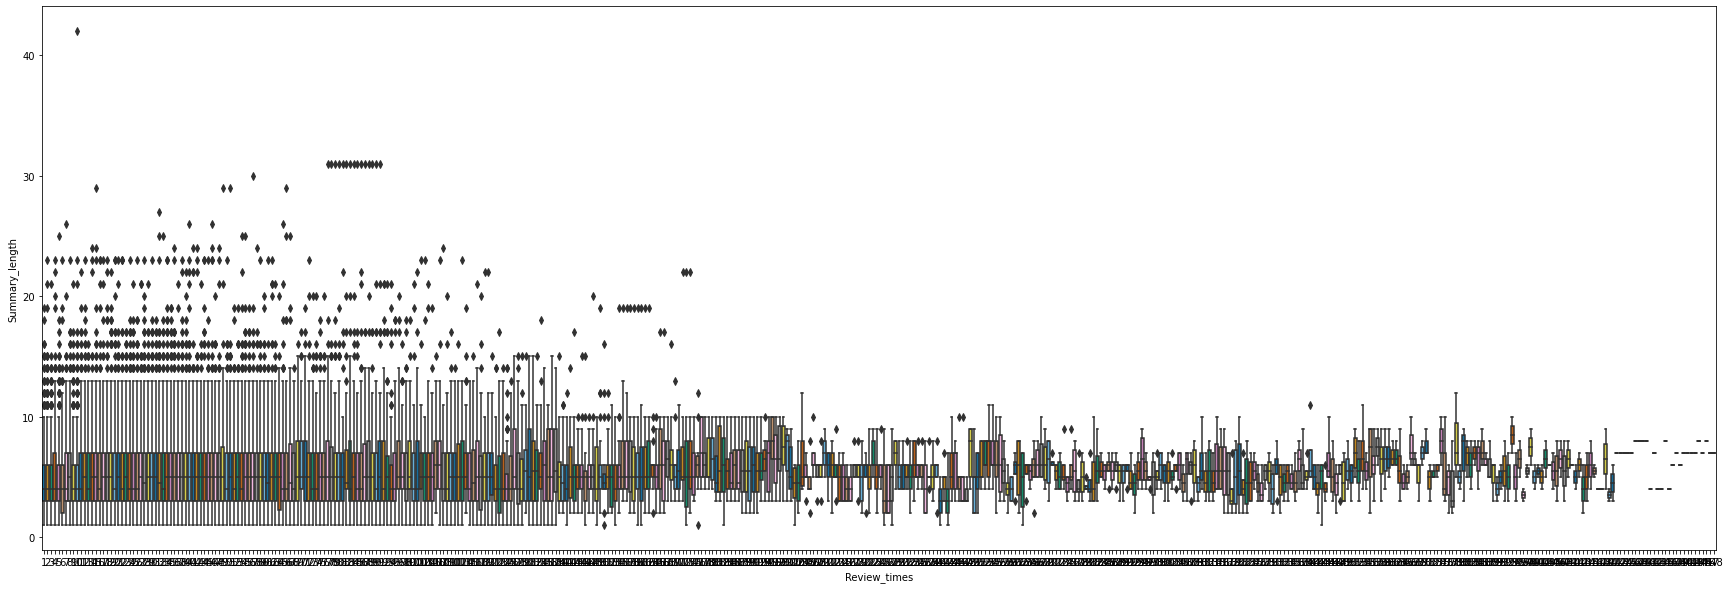

In [41]:
plt.figure(figsize=(30,10))
sns.boxplot(y='Summary_length',x='Review_times',data=top_users,palette="colorblind")
plt.show()

`Observe` plot shows summary text length
* Summary-Length is relatively consistent for a while in beginning and then begins to flucuate
* Starts becoming sparse at around 196 reviews as number of people writing more begins to drop off

In [42]:
summary_length_df = top_users.groupby(top_users.Review_times)[['Summary_length']].median()
summary_length_df.reset_index(level=0,inplace=True)
summary_length_df['Review_times'] = pd.to_numeric(summary_length_df['Review_times'])
summary_length_df.head()

,Review_times,Summary_length
0,1,4.0
1,2,4.0
2,3,4.0
3,4,4.0
4,5,4.0


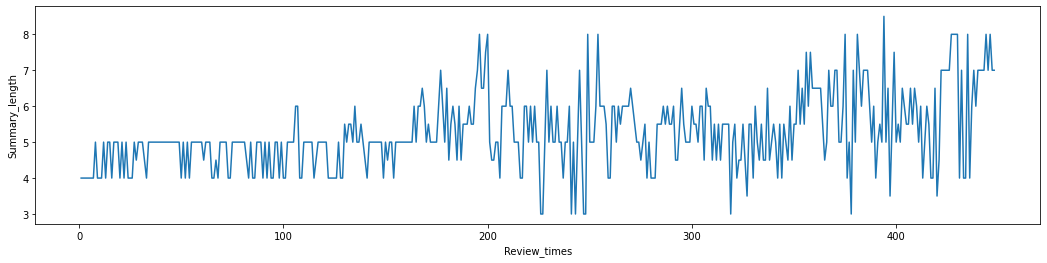

In [43]:
plt.figure(figsize=(18,4))
sns.lineplot(y='Summary_length',x='Review_times',data=summary_length_df)
plt.show()

`Observe` doing same thing with Summary-Length as with Text-Length
* Although it does fluctuate, it seems to actually increase overtime

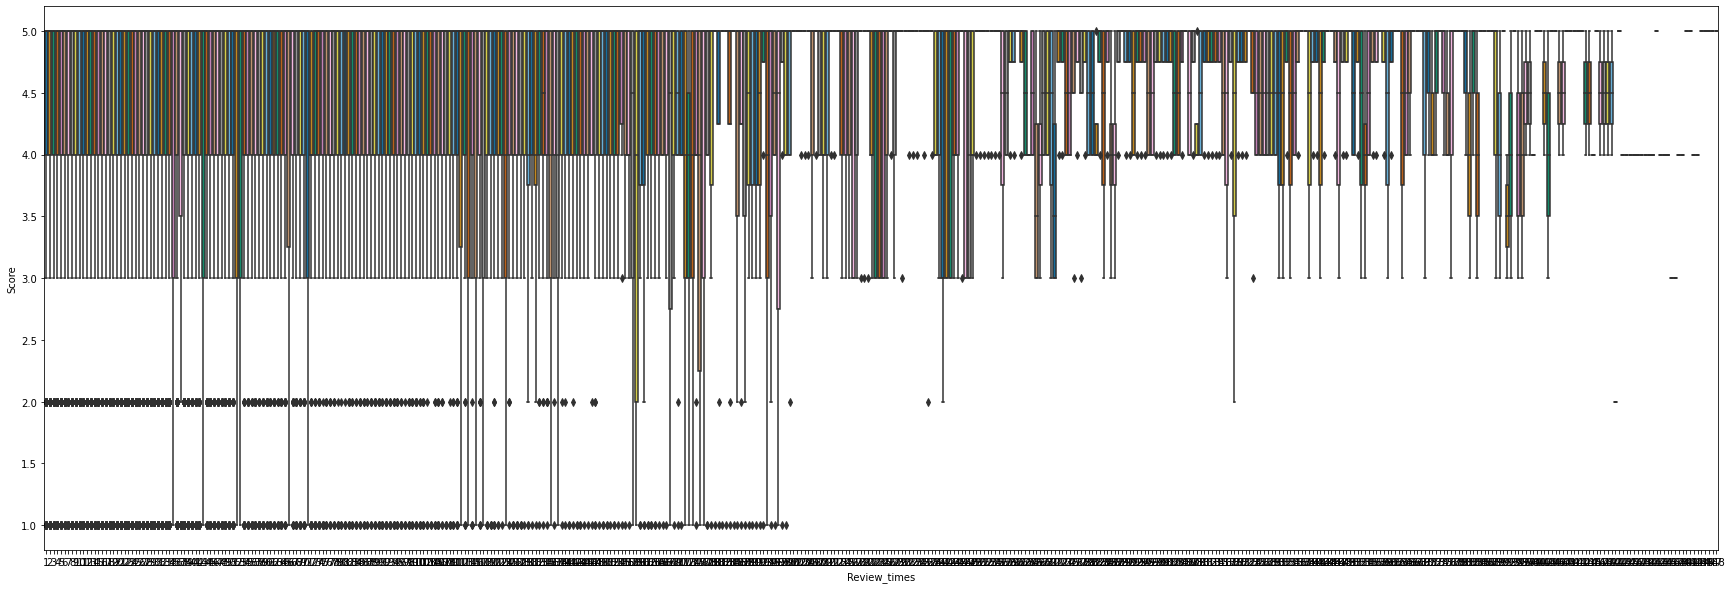

In [44]:
plt.figure(figsize=(30,10))
sns.boxplot(y='Score',x='Review_times',data=top_users,palette="colorblind")
plt.show()

`Observe` above shows box plots of review by Score
* A lot of effect of having mostly 5 star reviews in dataset
* Most of Q3 in box plots are 5 which makes sense 
* Sparseness and varying box plots near end can be seen

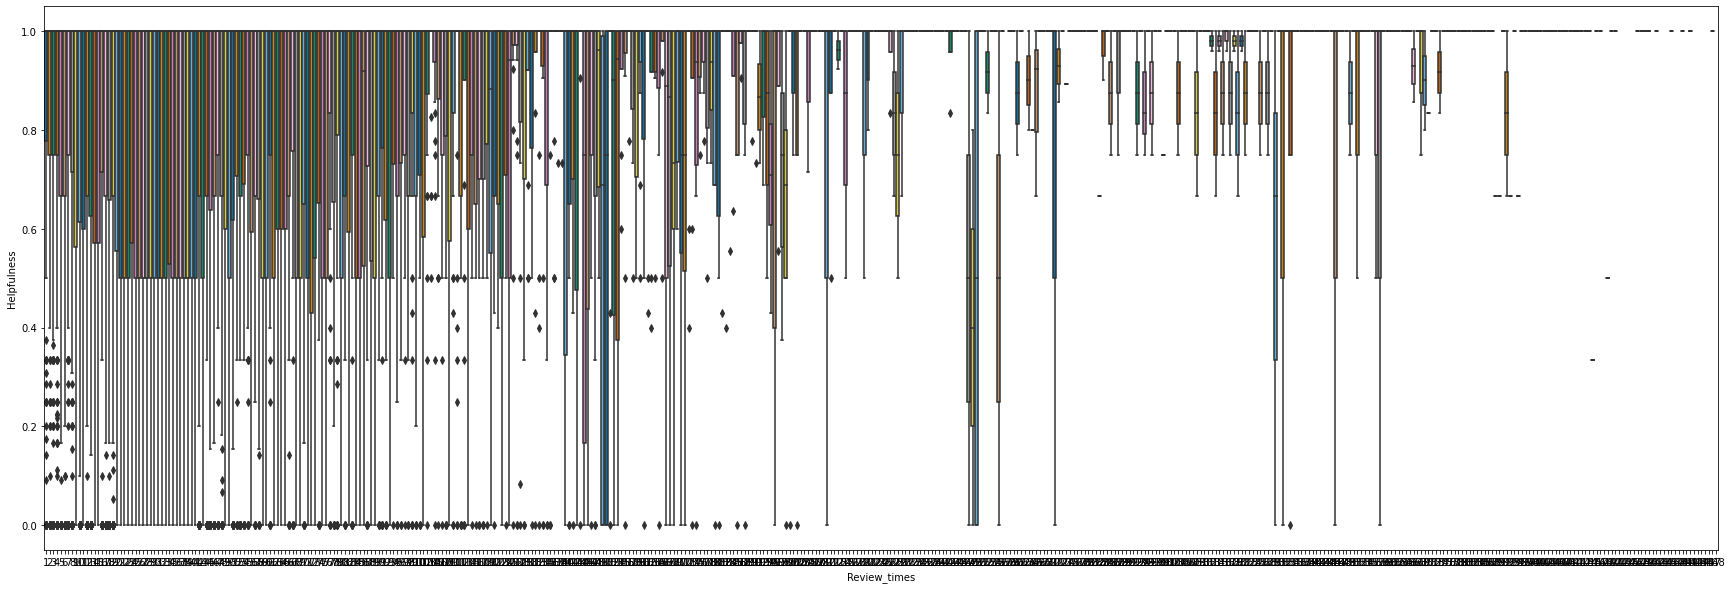

In [45]:
plt.figure(figsize=(30,10))
sns.boxplot(y='Helpfulness',x='Review_times',data=top_users,palette="colorblind")
plt.show()

`Observe` Finally, plot above is Helpfulness of Reviews
* Expectation here is that like people might be more interested in more prolific reviewers and give them more helpful scores
* From above box plots, there does not seem to be any specific trend but it would make sense if it were more time dependent rather than based on a specific reviewer

### Product Popularity (ProductId Feature)
To get an estimate of how popular an item is
* Trying to proxy this by number of reviews

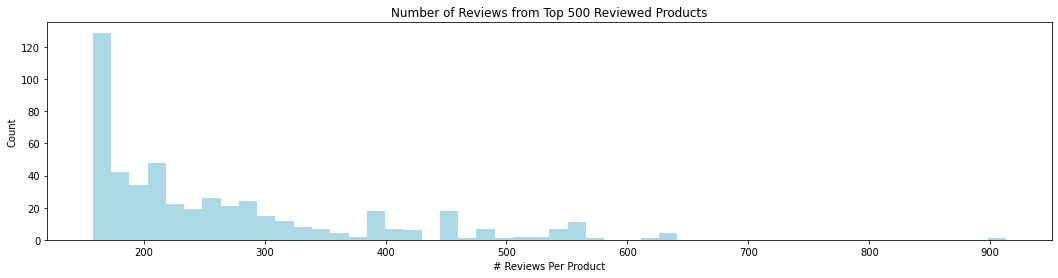

In [46]:
top_500_product_count = reviews["ProductId"].value_counts().nlargest(500)

plt.figure(figsize=(18,4))
plt.hist(top_500_product_count,bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Reviews Per Product')
plt.title('Number of Reviews from Top 500 Reviewed Products')
plt.show()

`Observe` in above plot there are top_500_reviewed products
* As expected number of reviews are right skewed
* Trying to take a summary look and see what mean score for these products are and trying to plotting it

In [47]:
top_products = reviews.loc[reviews['ProductId'].isin(top_500_product_count.index)]
top_products_mean = top_products.groupby('ProductId').mean().filter(['Score','Helpfulness','Text_length','Summary_length'])
top_products_mean.head()

,Score,Helpfulness,Text_length,Summary_length
ProductId,,,,
7310172001,4.751445,0.829295,69.612717,4.254335
7310172101,4.751445,0.829295,69.612717,4.254335
B00004CI84,4.486772,0.548719,114.962963,4.259259
B00004CXX9,4.405128,0.515356,111.728205,4.158974
B00004RAMY,4.104651,0.676509,142.558140,4.546512


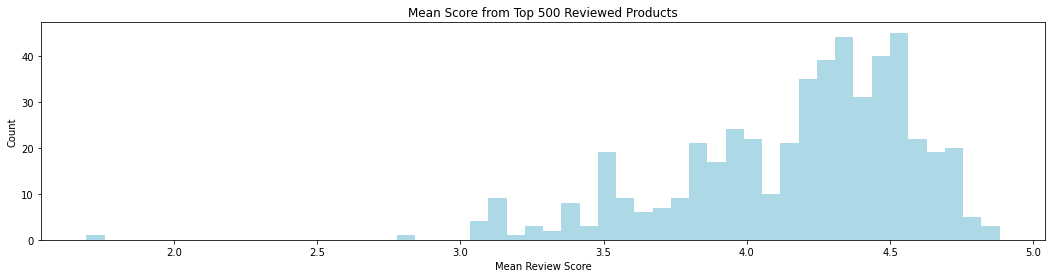

In [48]:
plt.figure(figsize=(18,4))

plt.hist(top_products_mean["Score"],bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Review Score')
plt.title('Mean Score from Top 500 Reviewed Products')
plt.show()

`Observe` plot above shows histogram of Mean_Score from top_500_products 
* It looks somewhat left skewed and has a multi-modal distribution
* Average stops any product from truly being 5 stars which is expected as we would expect to see some variation in reviews

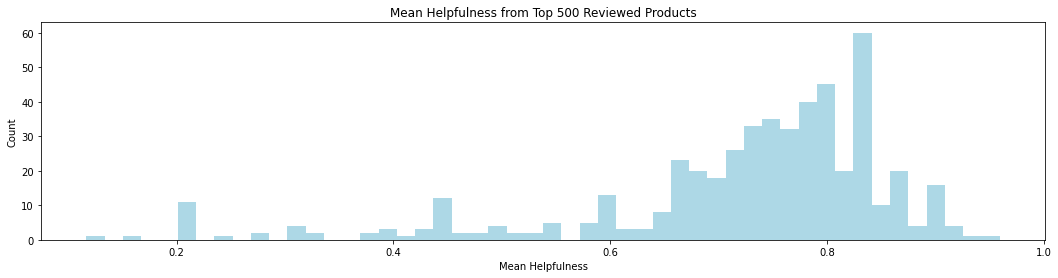

In [49]:
plt.figure(figsize=(18,4))

plt.hist(top_products_mean["Helpfulness"],bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Helpfulness')
plt.title('Mean Helpfulness from Top 500 Reviewed Products')
plt.show()

`Observ` in above plot similar pattern with Helpfulness with top_500_products
* None of review for these products are truly in concordance with helpfulness in either direction
* Getting a clear peak at around 0.8 which looks somewhat normal

**`Trying to understand if this Helpfulness has some Time based dependency`** 
* Calculating relative age of a product based on Last_Review date and 
* back calculate Review_Metrics and trying to visualize these trends

In [50]:
# getting last time per product for date diff
end_time = top_products.groupby('ProductId')['Time'].max()
#end_time = end_time.sort_values('ProductId')

# finding date diff per review
top_products['Age'] = top_products.apply(lambda d:end_time[d['ProductId']] - d['Time'],axis=1) / np.timedelta64(1,'D')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


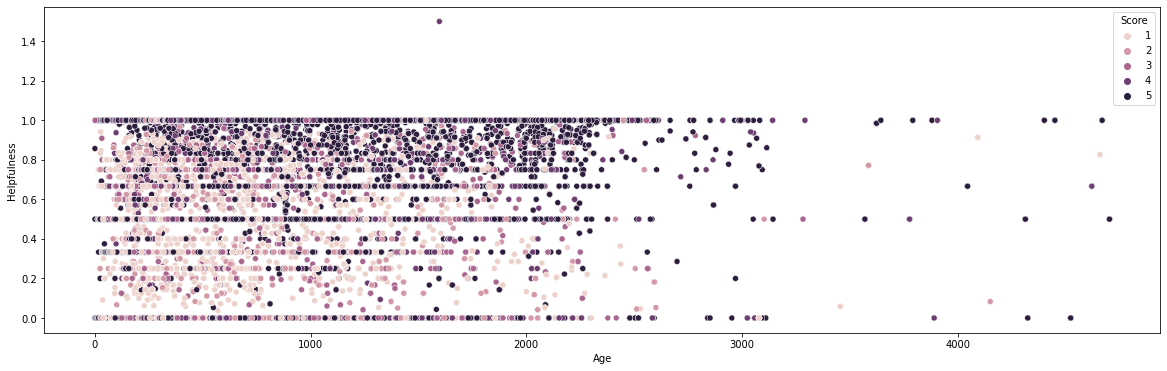

In [51]:
# scatter plot age to helpfulness
plt.figure(figsize=(20,6))
sns.scatterplot(x='Age',y='Helpfulness',hue='Score',data=top_products)
plt.show()

`Observe` from above scatter plot
* see some sort of clustering in Higher_Bounds after around 100 days with Helpfulness based on age and score
* A lot of High_Scored youngish reviews that are generally 5 star also tend to be positively reviewed
    * It looks like a lot of reviews for Similar age but lower scores tend to be rated not as helpful
* We can try clustering to see if we can better visualize these clusters
    * It still looks incredibly noisy and there doesn't seem like any specfic trend with age and helpfulness but maybe we can get lucky with some clustering
    
**`First, we should do Histogram of Age to confirm what it looks like`**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


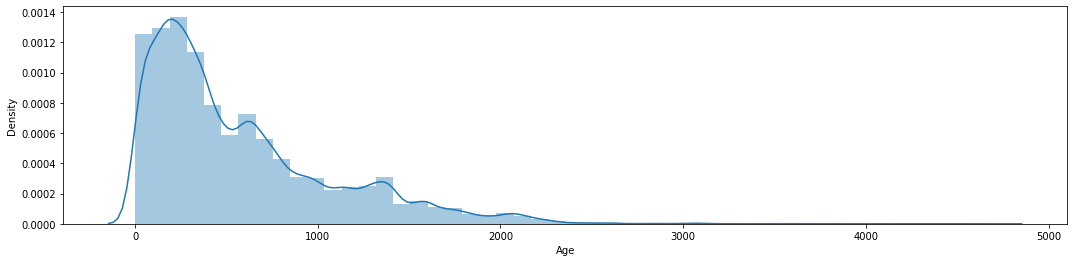

In [52]:
# scatter plot histogram age and helpfulness
plt.figure(figsize=(18,4))
sns.distplot(top_products["Age"])
plt.show()

`Observe` in scatter plot above
* most of data is for relatively newer products
* These values are generated from date difference between date_of_writing and oldest_review so it stays to reason that a lot of these reviews are relatively newer but still relatively old products
* Next, it can tryied `T-Sne` to see if we can separate out Helpfulness and Age

In [53]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,verbose=0,perplexity=40,n_iter=300)
tsne_results = tsne.fit_transform(top_products[['Age','Helpfulness']].dropna())

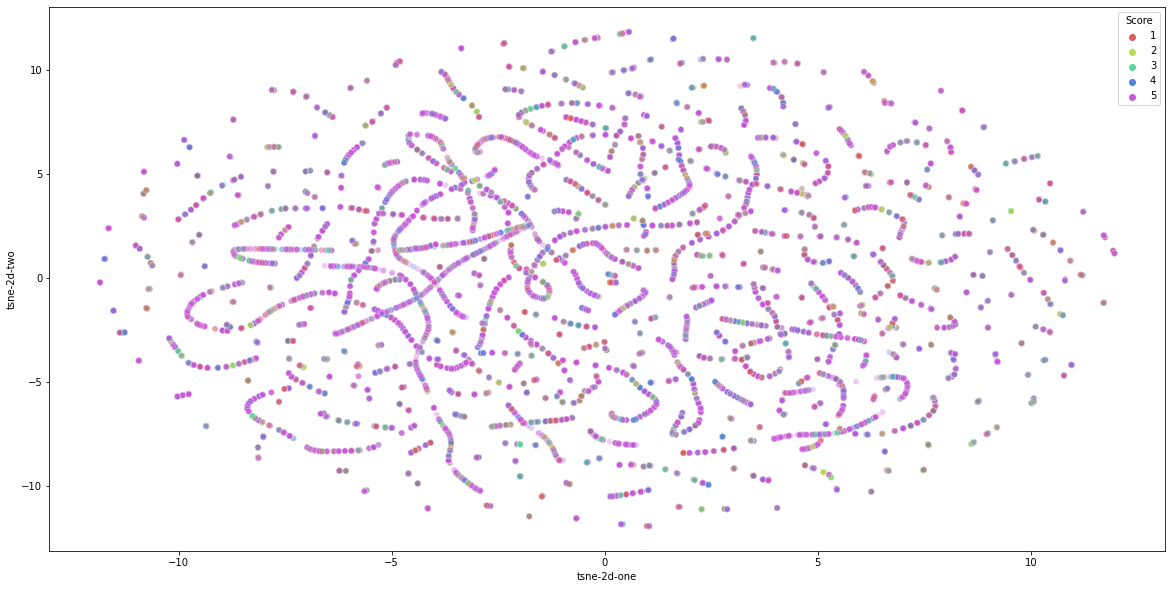

In [54]:
df_subset = top_products[['Age','Helpfulness','Score']].dropna()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(20,10))
sns.scatterplot(x='tsne-2d-one',y='tsne-2d-two',hue="Score",data=df_subset,legend="full",alpha=0.3,palette=sns.color_palette("hls",5))

plt.show()

`Observe` although interesting looking, there is no clear pattern with TSNE which would suggest that is hard to separate features given how much overlap they have with each other

**`Trying to plot median again as a line plot to try to track trends based on Number_of_Days`**

In [55]:
top_products.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Summary_length,Text_length,Text_sentiment,Summary_sentiment,Age
422,423,B000G6RYNE,A2NO1TXXS9T0EE,BruteNStones,0,0,4,2012-04-26,Hard,"Great if you are cutting back on fat, they do ...",NaN,1,22,Negative,Negative,173.0
423,424,B000G6RYNE,A1IRN1M05TPOVT,"Sharon M. Helfand ""Scrapper""",0,0,5,2012-04-17,Kettle potato chips: Fully loaded baked potato,I have never met a Kettle brand chip I did not...,NaN,7,51,Positive,Neutral,182.0
424,425,B000G6RYNE,ARONI7W0W677H,Peter N,0,0,5,2012-04-13,"Fresh, Lightly-Spiced, Crunchy Kettle Chips. G...",After buying bags one at a time (at a hefty ma...,NaN,9,141,Positive,Positive,186.0
425,426,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,2012-04-10,glad to find them in 1 oz size,"I buy mostly for vending, so the size of the b...",NaN,8,41,Positive,Positive,189.0
426,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,2012-04-10,"pretty good, could be better",Glad to find these in a one ounce size but the...,NaN,5,52,Positive,Positive,189.0


In [56]:
age_helpfulness_df = top_products.groupby([top_products.Age, top_products.Score])[['Helpfulness']].mean()
age_helpfulness_df.reset_index(level=0,inplace=True)
age_helpfulness_df.reset_index(level=0,inplace=True)
#age_helpfulness_df['Helpfulness'] = pd.to_numeric(age_helpfulness_df['Helpfulness'])
age_helpfulness_df.head()

,Score,Age,Helpfulness
0,1,0.0,0.833333
1,2,0.0,0.714286
2,3,0.0,0.750000
3,4,0.0,1.000000
4,5,0.0,0.796703


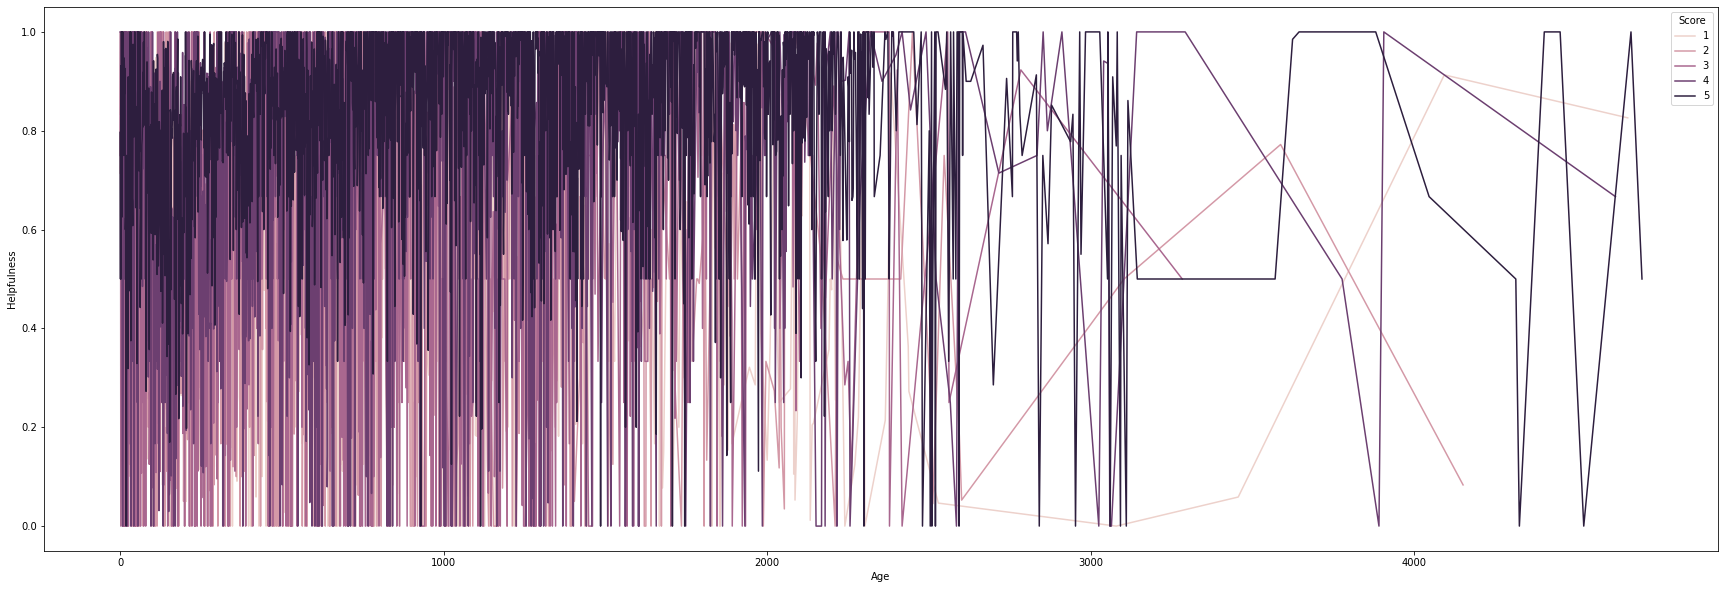

In [57]:
plt.figure(figsize=(30,10))
sns.lineplot(y='Helpfulness',x='Age',hue='Score',data=age_helpfulness_df)
plt.show()

`Observ` plot above shows line plot of different Scores and Over_Time in relation to mean Helpfulness
* In general, it looks like mean Helpfulness fluctuate but mostly become more positive over time until we start getting sparsity issues with anything past ~2100 days
* It looks like other scores somewhat follow same pattern and mostly trend upwards overtime until it has sparisity issues as well

**`Next, looking at similar metrics and visualize mean summary length of top most reviewed products`**

In [58]:
# Wanting to try to figure how out to do Helpfulness overtime
end_time = top_products.groupby('ProductId')['Time'].max().reset_index()

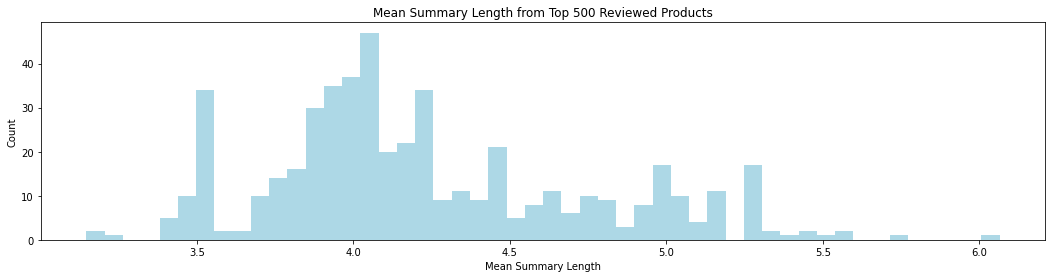

In [59]:
plt.figure(figsize=(18,4))
plt.hist(top_products_mean['Summary_length'],bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Summary Length')
plt.title('Mean Summary Length from Top 500 Reviewed Products')
plt.show()

`Observ` it looks like mean_summary_length is relatively short
* It looks more right tailed with maximum at around 4

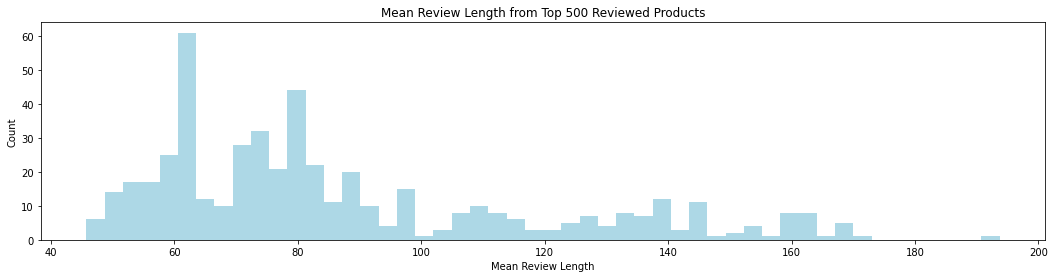

In [60]:
plt.figure(figsize=(18,4))
plt.hist(top_products_mean['Text_length'],bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('Mean Review Length')
plt.title('Mean Review Length from Top 500 Reviewed Products')
plt.show()

`Observ` mean length seems to vary quite a bit
* It seems bimodal at around 55 words and 80 words and then dropping off

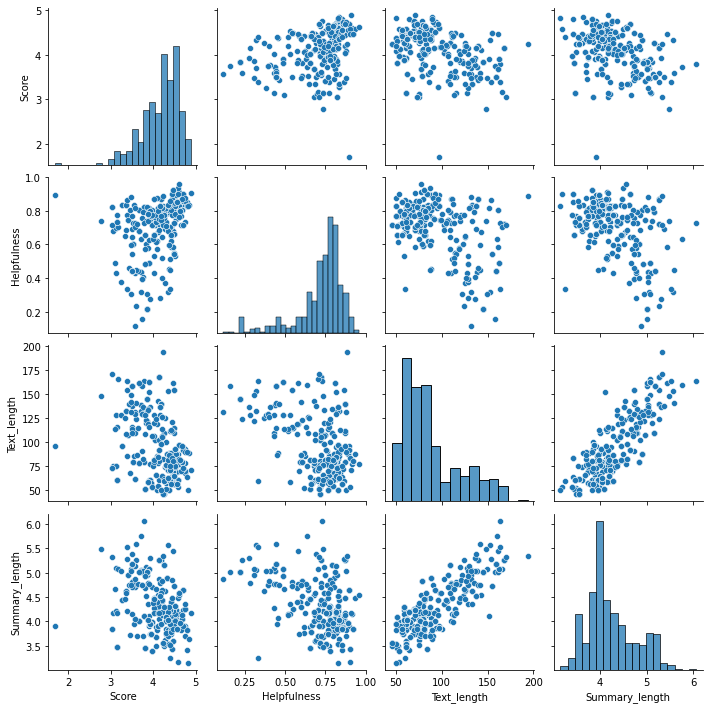

In [61]:
sns.pairplot(top_products_mean)
plt.show()

`Observ` pair plot is showinf some general trends
* Relationship between mean score and other features are nonlinear
* Most interesting relationship is length of reviews and summary which look very strongly correlated

### Review Length (Summary_Length and Text_Length Feature) 

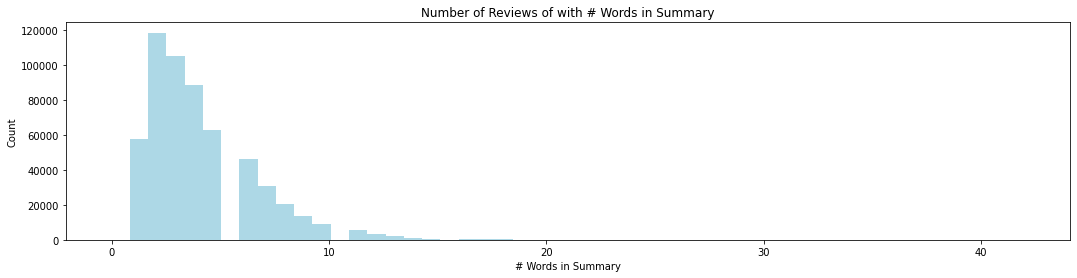

In [62]:
plt.figure(figsize=(18,4))
plt.hist(reviews['Summary_length'],bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Words in Summary')
plt.title('Number of Reviews of with # Words in Summary')
plt.show()

`Observ` plot shows that Summary_Length is right skewed

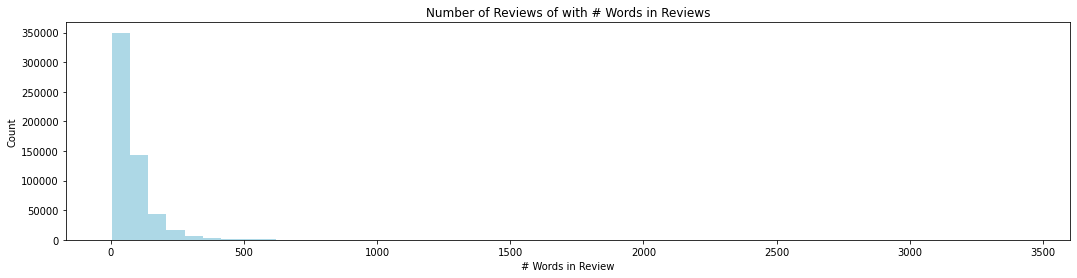

In [63]:
plt.figure(figsize=(18,4))
plt.hist(reviews['Text_length'],bins=50,color='lightblue')
plt.ylabel('Count')
plt.xlabel('# Words in Review')
plt.title('Number of Reviews of with # Words in Reviews')
plt.show()

`Observ` similar to summary, we see that distribution here is right skewed

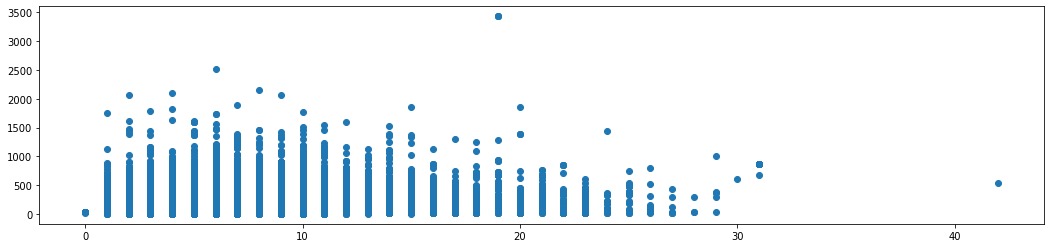

In [64]:
# scatter plot of summary_length and review_length
plt.figure(figsize=(18,4))
plt.scatter(reviews["Summary_length"], reviews["Text_length"])
plt.show()

`Observ` while ploting two lengths against each other, there is no obvious relationship between number_of_words in summary to review

**`Interested in seeing if two variables have any relationship between each othe`**
* can run Spearman_Correlation as both variables are nonparametric

In [65]:
# calculating spearman's correlation
coef, p = spearmanr(reviews['Summary_length'], reviews['Text_length'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpreting significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.305
Samples are correlated (reject H0) p=0.000


`Observ`
* can see from above that correlation is weak but statistically significant in that there is some true relationship between two variables

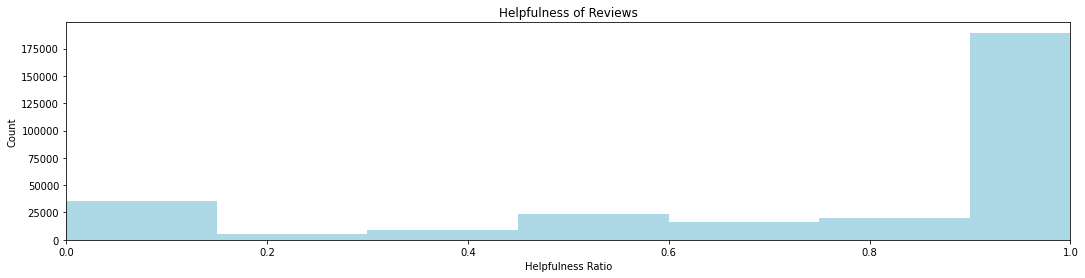

In [66]:
plt.figure(figsize=(18,4))

plt.hist(reviews['Helpfulness'],bins=20,color='lightblue')
plt.ylabel('Count')
plt.xlabel('Helpfulness Ratio')
plt.title('Helpfulness of Reviews')
plt.xlim(0,1)
plt.show()

`Observ` in above plot most of Helpful_Ratio is left skewed
* This could be expected as many reviews might have been rated helpful once which would heavily bias this score
* It can be checked by filtering out the single rated entries

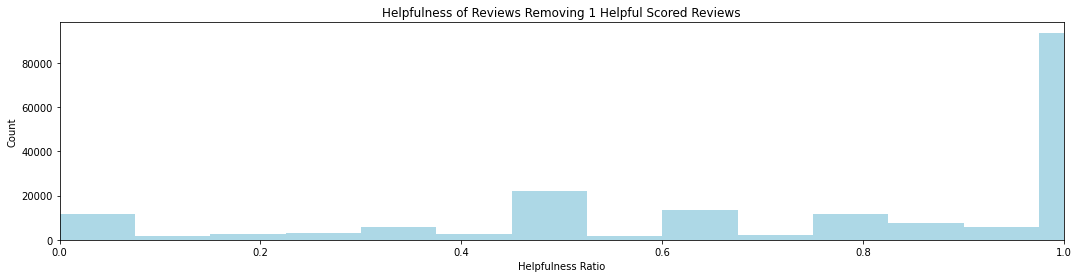

In [67]:
plt.figure(figsize=(18,4))

plt.hist(reviews[reviews['HelpfulnessDenominator'] != 1]['Helpfulness'].dropna(), bins=20, color='lightblue')
plt.ylabel('Count')
plt.xlabel('Helpfulness Ratio')
plt.title('Helpfulness of Reviews Removing 1 Helpful Scored Reviews')
plt.xlim(0,1)
plt.show()

`Observ` getting a more interesting pattern here
* above plot shows same Helpfulness_Ratio but removing all reviews that were scored once
* number of entries drops by above half
    * In addition, still see left skewed tendencies of this plot

**`Finally, trying to see how these compare with our scores`**

### Relationship of Score

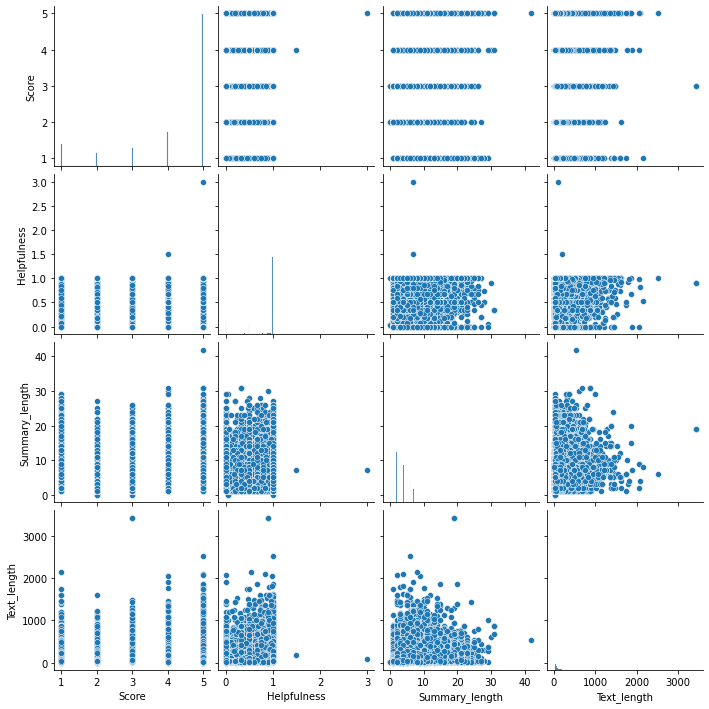

In [68]:
sns.pairplot(reviews[['Score','Helpfulness','Summary_length','Text_length']])
plt.show()

`Observe` see pairwise plots in relation to Score
* none of these features are very clear differentiators to score
* longer reviews might be a differentiator for higher scores otherwise there is not much signal
* can do a box_plot to get a stronger sense of if these numerical variables mean anything

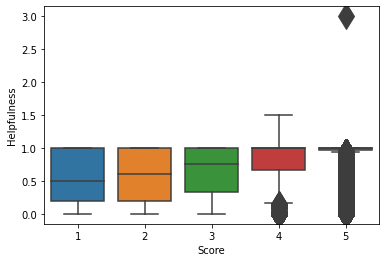

In [69]:
# to get a stronger sense of if above numerical variables mean anything
sns.boxplot(x='Score',y='Helpfulness',data=reviews,fliersize=18)
plt.show()

`Observ` in above plot , Score in relation to Helpfulness_Ratio shows patterns in median 
* With scores of 4 and 5 median pushed all way to almost 1.0
* There interestingly are outliers for score 5
* can examine what they are

In [70]:
reviews[reviews['Helpfulness'] > 1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Summary_length,Text_length,Text_sentiment,Summary_sentiment
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,2008-06-08,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,1.5,7,184,Positive,Neutral
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,2008-10-25,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,3.0,7,87,Positive,Neutral


`Observ` not expected and it is not clear why Denominator is not total
* It could be a sample collection error

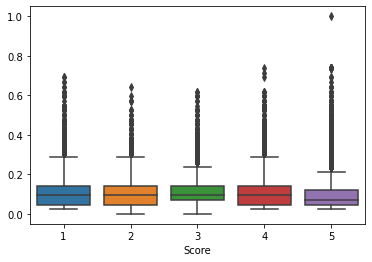

In [71]:
from sklearn.preprocessing import minmax_scale

sns.boxplot(x=reviews['Score'],y=minmax_scale(reviews['Summary_length']))
plt.show()

`Observ` boxplot above shows Score vs min-max_scaled version of Summary_Length
* there is not clear pattern between different scores
* median and box are tighter in score 5 but as there are more samples, it makes sense

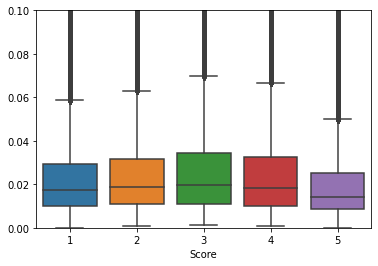

In [72]:
sns.boxplot(x=reviews['Score'], y=minmax_scale(reviews['Text_length'])).set(ylim=(0, 0.1))
plt.show()

`Observ` box plot of Score vs min-max_Normalized version of text length
* y-axis limits are modified otherwise box is not distinguishable
    * can see that medians are all roughly same between different scores

* Using non-text variables, it does not seem like any of Features are strong enough to distinguish itself as primary driver for these review scores


**`Trying to investigate reviews and summary to see if there is any interesting observations`**

### Reviews and Summary Overview
Bulk of this dataset lies in Reviews and the Summary tagline of the review
* There might be something in either of those features which might be interesting for classification
* Additionally, it would be interesting to understand those features for general data anlysis to understand Reviewers better

First, TF-IDF will be calculated high level overview of what these corpus looks like
* We will only be checking unigram for keyword checks and removing stop words, numeric, lemmatization and removing punctuation
* As number of documents are relatively large, a portion of it will be sampled prior to anallysis

In [73]:
# approx 2.1989466166127776% of reviews 
reviews_sampled = reviews.sample(12500,random_state=108) 

In [74]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer


nlp = spacy.load("en_core_web_sm")

In [75]:
def simple_tokenizer(corpus,nlp=nlp):
    """ 
    Give a sentence and return tokenized string given 
    lemmanization, stop word remove, punctuation removal, and alpha characters only
    """
    doc = nlp(corpus)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

In [76]:
#from sklearn.pipeline import Pipeline
#tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer(tokenizer = simple_tokenizer))])
#tfidf_pipe.fit_transform(reviews['Summary'][0:10], reviews['Text'][0:10])

In [77]:
print('Starting Summary TF-IDF')
tfidf_s = TfidfVectorizer(tokenizer = simple_tokenizer)
tfidf_summary = tfidf_s.fit_transform(reviews_sampled['Summary'])
print('Starting Review TF-IDF')
tfidf_r = TfidfVectorizer(tokenizer = simple_tokenizer)
tfidf_reviews = tfidf_r.fit_transform(reviews_sampled['Text'])

Starting Summary TF-IDF
Starting Review TF-IDF


In [78]:
features_name = tfidf_r.get_feature_names()
print(features_name)

['aa', 'aaaaaaarrrrrggghhh', 'aaaah', 'aaaahhhhhh', 'aadd', 'aadmit', 'aafco', 'aah', 'abalone', 'abandon', 'abbie', 'abc', 'abdoman', 'abdominal', 'aber', 'abhor', 'abhorant', 'abide', 'ability', 'abit', 'able', 'abnormal', 'abnormality', 'abnormally', 'abode', 'abominably', 'abomination', 'aboslutely', 'abosutely', 'abound', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absolve', 'absorb', 'absorber', 'absorption', 'absoulte', 'absoultely', 'absoulutely', 'abstain', 'absurd', 'absurdity', 'abt', 'abundance', 'abundant', 'abuse', 'abv', 'abysmal', 'ac', 'acacia', 'academy', 'acai', 'acana', 'accelerate', 'accent', 'accept', 'acceptable', 'access', 'accessible', 'accessory', 'accident', 'accidental', 'accidentally', 'accidently', 'accolade', 'accommodate', 'accomodate', 'accompaniement', 'accompaniment', 'accompany', 'accomplish', 'accomplished', 'accomplishment', 'accord', 'accordingly', 'accore', 'account', 'accounting', 'accoutrement', 'accredi

In [79]:
# top 40 tf_idf features for reviews
indices = np.argsort(tfidf_s.idf_)[::-1]
features = tfidf_s.get_feature_names()

top_n = 40
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['lemonhead', 'hypoallergenic', 'imo', 'immunity', 'immediately', 'imho', 'illogical', 'illi', 'iggy', 'iffy', 'ide', 'hypoglycemia', 'hurry', 'hotcake', 'hunter', 'hungry', 'humorous', 'hummis', 'humbug', 'huckleberry', 'htf', 'hrs', 'hottie', 'hotness', 'important', 'inc', 'incomplete', 'indestructible', 'insurance', 'insomniac', 'insist', 'insanely', 'insane', 'innova', 'ink', 'initely', 'inhouse', 'infusion', 'info', 'inflammatory']


`Observ` top 40 tf-idf features from this sample
* Although some of these tokens are typos, see that the tokens are a mixture of slang for positive things and food related words

In [80]:
# top 40 tf idf features for reviews
indices = np.argsort(tfidf_r.idf_)[::-1]
features = tfidf_r.get_feature_names()

top_n = 40
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['çelem', 'jammed', 'jambalaya', 'jamba', 'jamacian', 'jaipur', 'jahren', 'jagged', 'jager', 'jacobs', 'jacksonhole', 'jackpot', 'jab', 'izzy', 'iwth', 'iwill', 'ivs', 'ivory', 'iveta', 'jambo', 'jammie', 'jessica', 'jammin', 'jerkyusa', 'jennifer', 'jemima', 'jellys', 'jellybean', 'jel', 'jefferson', 'jeans', 'jd', 'jcpenney', 'jawbreaker', 'jato', 'jason', 'jasmime', 'jarring', 'jared', 'janis']


`Observ` box above shows top features for actual reviews
* can see some typos and some non-english terms
* From here, can mostly see that original and some physical ailments are getting higher TF-IDF values

Got General idea of what text_data looks like
* Now can go one step further
    * Trying to find top_words given each year of reviews in our dataset
    * `It would be interesting to see if we can capture trend in gourmet foods over year using reviews`

**`First, Imputing Score to be Binary_Classifcation using scores of 4-5 as High and everything else as Low`**

In [81]:
# updating score as binary 
reviews['Score_bc'] = reviews['Score'] >= 4
reviews['Score_bc'] = reviews['Score_bc'].astype('category')
reviews.replace({'Score_bc':{True:'High',False:'Low'}},inplace=True)
reviews['Score_bc'].head()

0    High
1     Low
2    High
3     Low
4    High
Name: Score_bc, dtype: object

**`Next, Setup Scattertext plots of every year of this corpus to get a sense of how things changed over time`**
* To again see which years we have in dataset, following can be done:

In [82]:
pd.DatetimeIndex(reviews['Time']).year.value_counts()

2012    198659
2011    163299
2010     85884
2009     55326
2008     34163
2007     22300
2006      6671
2005      1335
2004       561
2003       132
2002        73
2000        32
2001        13
1999         6
Name: Time, dtype: int64

**`Now creating plots`**

In [83]:
#!pip install scattertext
import scattertext as st

In [95]:
nlp = spacy.load('en_core_web_sm')
def produce_scattertext(nlp=nlp,year=1999,col='Text'):
    """ 
    Create scatter_text based on a given year and text column 
    """
    filtered_reviews = reviews[pd.DatetimeIndex(reviews['Time']).year == year]
    print("Creating corpus for " + str(year))
    
    # turning it into a Scattertext Corpus 
    corpus = st.CorpusFromPandas(filtered_reviews,category_col='Score_bc',text_col=col,nlp=nlp).build()
    print("Creating plot")
    
    # output scattertext html files
    html = st.produce_scattertext_explorer(corpus,category='High',category_name='High Score',
                                           not_category_name='Low Score',width_in_pixels=1000,metadata=filtered_reviews["Score"])
    open("link where you want 2 save/" + str(year) + ".html", 'wb').write(html.encode('utf-8'))
    
    print("Finished Scattertext")
    

In [92]:
# creating plots (1999 all positive)
produce_scattertext(year = 2000)
produce_scattertext(year = 2001)
produce_scattertext(year = 2002)
produce_scattertext(year = 2003)
produce_scattertext(year = 2004)
produce_scattertext(year = 2005)
produce_scattertext(year = 2006)
produce_scattertext(year = 2007)
produce_scattertext(year = 2008)
produce_scattertext(year = 2009)
produce_scattertext(year = 2010)
produce_scattertext(year = 2011)
produce_scattertext(year = 2012)

Creating corpus for 2000
Creating plot
Finished Scattertext
Creating corpus for 2001
Creating plot
Finished Scattertext
Creating corpus for 2002
Creating plot
Finished Scattertext
Creating corpus for 2003
Creating plot
Finished Scattertext
Creating corpus for 2004
Creating plot
Finished Scattertext
Creating corpus for 2005
Creating plot
Finished Scattertext
Creating corpus for 2006


KeyboardInterrupt: 

## `Goal of creating Scattertext` 
Goal is to get an understand per year of why people gave ratings of 4-5 and why they gave lukewarm or bad reviews of 1-3
* Can see several trends when you open up scatter_text
    * 1999 was not plotted as sample size was very small and it appears that only highly rated reviews were available
    
* `Year 2000` was mostly movie reviews
    * In particular people seem to like beetle juice
* `Year 2001` was still related to movies
    * In particular people seem to prefer wide screen movies and disliked dvds
    * Perhaps this is around the rise of dvds as the Playstation 2 was released in 2000
* `Year 2002` is more ambiguous as top scored words are mostly stop words, It is still movie reviews and makes reference to beetlejuice as well as probably Tim Burton
    * It also references what is likely the Matrix 2 as some of actors and actresses are in dataset
* `Year 2003` is when dataset begins to closer mention gourmet foods, It still has movie mentions and some dirty html tags but seems to have high number of chocolate and coffee related terms
    * Starbucks is specifically mentioned and in 2003, Starbucks bought out Seattle Coffee Company and expanded about 2000 stores
    * This is likely a 2nd wave coffee shop trend
* `Year 2004` is a more interesting year, There is still a large influence from Beetlejuice and Tim burton but two trends here seem to be tea and urinary tract infections and sugar
    * It seems people are concerned about sugar intake this year
    * Senseo is also a top characteristic of these reviews and it appears that it started to appear in 2003
        * Senseo seems like an early Keurig machine designed to simplify coffee using pods
* `Year 2005` seems to sweets related. We have many interesting terms here including coffee, tea, sweeteners, jarritos, larabar, and kashi
    * It seems this year is when health fad happened and people began to worry about type of sugars in their products
    * According to wikipedia, 2006 was when the WHO released a report saying stevia was safe for consumption so maybe it is related
    * In top scored tokens, chocolate and tea have high scores
    * Reviews with low score seem to be price and expediated delivery related
* `Year 2006` seems to be dominated by cat food reviews, Looking in top and low scores, they seem to refer to either cats or dogs and feeding them good food
    * This might be related to characteristic terms for kibble and canidae which begun appearing in earlier years
    * The trends for food according to characteristics seem relatively similar to 2005
    * We see more gum, oreos, larabars, teas, pretzels, noodles, and snacks
        * This might be Amazon deciding to expand their food selection to more unhealthier snacks.
* `Year 2007` has more diverse terms. Specifically, characteristics are more desriptive compared to 2006 which was more specific products
    * The top scores are mostly relatively positive words that you would expect from reviews like delicious
    * The low scores are lower sentiment values and are works like disappointed or terrible
    * There seems to be complaints about pumps and that is related to a water pump for a hydroponic gardening kit from AeroGarden
* `Year 2008` has many descriptive adjectives. There are still brands that are picked up including izze, canidae but it is mostly generic terms now
    * The interesting thing is that there seemed to have been some issue with menadione and new formula for canidae which is very poorly received
* `Year 2009` still contained many adjectives. It seems like Canidae formula changing controversy still continued in reviews
    * Interestingly, there seems to be an issue with Made in China this year
    * Looking at some of the reviews, it seems to be dog treat related
* `Year 2010` continued trend as seen in previous years, It seems pasta and snacks became very indicative of high scores
    * Some of interesting characteristics that have been added are gluten and keurig which are known for their coffee pods
    * Investigating thought see which has top low score shows that there is someone reposting same negative 1 star review over and over
* `Year 2011` only has Amazon as only named entity, All of the primary features follow last couple of year in trends in that it is mostly adjectives
    * We can see in plot of high score frequent tokens that we have specific foods people are interested in
    * There is also interestingly some holistic references including outlier term uterus
    * Negative reviews seems to be complaints based on expiration or taste
* `Year 2012` shows similar trends as before, We can see that people are still complaining about things made in China
    * It seems matcha and magnesium are very highly rated
    * In plot, we can see certain products people don't seem to like such as hammer products and potentially turbinado sugar
    * People also seem to be wory of propylene glycol which is a flavorless additive to food
    * Looking at some of strange postiive frequent words, we can see that there is review replication such as for causes diarrhea